<a href="https://colab.research.google.com/github/DinurakshanRavichandran/Visio-Glance/blob/OCT-eye-disease-detection/CourseworkModel2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Exploratory Data Analysis

### EDA Manual

In [ ]:
import zipfile

# Path to the zipped dataset in your Drive
zip_path = '/content/drive/MyDrive/Machine learning/Dataset/OCT Dataset/Train/archive.zip'

# Set extraction path in Colab
extract_path = '/content/OCT_Dataset'

# Unzipping the dataset
with zipfile.ZipFile(zip_path, 'r') as zip_ref:
    zip_ref.extractall(extract_path)

print("Dataset unzipped successfully!")

Dataset unzipped successfully!


Processing images: 0it [00:00, ?it/s]


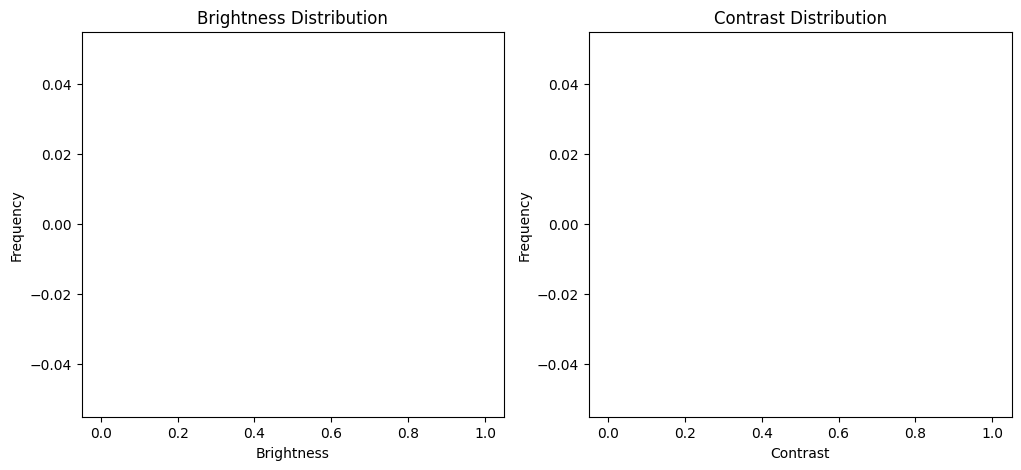

In [ ]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
import os
from tqdm import tqdm

def compute_brightness_contrast(image_path):
    """
    Compute the brightness (mean pixel intensity) and contrast (standard deviation of pixel intensity).
    """
    image = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)  # Convert to grayscale
    brightness = np.mean(image)  # Average pixel intensity
    contrast = np.std(image)  # Standard deviation of pixel intensity
    return brightness, contrast

def analyze_brightness_contrast(image_dir):
    """
    Analyze brightness and contrast for all images in a given directory.
    """
    brightness_values = []
    contrast_values = []

    image_files = [f for f in os.listdir(image_dir) if f.endswith(('.png', '.jpg', '.jpeg'))]

    for img_file in tqdm(image_files, desc="Processing images"):
        img_path = os.path.join(image_dir, img_file)
        brightness, contrast = compute_brightness_contrast(img_path)
        brightness_values.append(brightness)
        contrast_values.append(contrast)

    # Plot distributions
    plt.figure(figsize=(12, 5))

    plt.subplot(1, 2, 1)
    plt.hist(brightness_values, bins=30, color='blue', alpha=0.7)
    plt.xlabel("Brightness")
    plt.ylabel("Frequency")
    plt.title("Brightness Distribution")

    plt.subplot(1, 2, 2)
    plt.hist(contrast_values, bins=30, color='red', alpha=0.7)
    plt.xlabel("Contrast")
    plt.ylabel("Frequency")
    plt.title("Contrast Distribution")

    plt.show()

# Example Usage
train_dir = '/content/OCT_Dataset/OCT2017 /train'
analyze_brightness_contrast(train_dir)

val_dir = '/content/OCT_Dataset/OCT2017 /val'
analyze_brightness_contrast(val_dir)

test_dir = '/content/OCT_Dataset/OCT2017 /test'
analyze_brightness_contrast(test_dir)





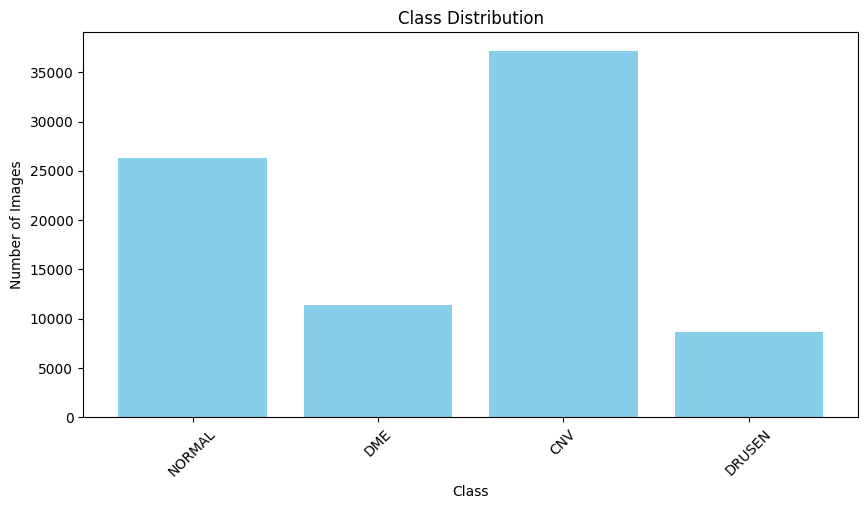

In [ ]:
import os
import matplotlib.pyplot as plt

def plot_class_distribution(dataset_path):
    """
    Plot the distribution of classes in a dataset.
    """
    class_counts = {}

    for class_name in os.listdir(dataset_path):
        class_dir = os.path.join(dataset_path, class_name)
        if os.path.isdir(class_dir):
            num_images = len([f for f in os.listdir(class_dir) if f.endswith(('.png', '.jpg', '.jpeg'))])
            class_counts[class_name] = num_images

    # Plot distribution
    plt.figure(figsize=(10, 5))
    plt.bar(class_counts.keys(), class_counts.values(), color='skyblue')
    plt.xlabel("Class")
    plt.ylabel("Number of Images")
    plt.xticks(rotation=45)
    plt.title("Class Distribution")
    plt.show()

# Example Usage
train_dir = '/content/OCT_Dataset/OCT2017 /train'
plot_class_distribution(train_dir)


In [ ]:
import numpy as np
import cv2

def compute_pixel_diversity(image_dir):
    """
    Calculate the diversity of pixel values across all images.
    """
    unique_pixels = set()
    image_files = [f for f in os.listdir(image_dir) if f.endswith(('.png', '.jpg', '.jpeg'))]

    for img_file in tqdm(image_files, desc="Analyzing pixel diversity"):
        img_path = os.path.join(image_dir, img_file)
        image = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)  # Grayscale for simplicity
        unique_pixels.update(np.unique(image))  # Add unique pixel values to the set

    print(f"Total unique pixel values across dataset: {len(unique_pixels)}")

# Example Usage
train_dir = '/content/OCT_Dataset/OCT2017 /train'
compute_pixel_diversity(train_dir)


Analyzing pixel diversity: 0it [00:00, ?it/s]

Total unique pixel values across dataset: 0


In [ ]:
import imagehash
from PIL import Image

def find_duplicate_images(image_dir):
    """
    Detect duplicate images based on perceptual hashing.
    """
    image_hashes = {}
    duplicates = []

    image_files = [f for f in os.listdir(image_dir) if f.endswith(('.png', '.jpg', '.jpeg'))]

    for img_file in tqdm(image_files, desc="Checking for duplicates"):
        img_path = os.path.join(image_dir, img_file)
        image = Image.open(img_path)
        img_hash = imagehash.phash(image)  # Perceptual hash

        if img_hash in image_hashes:
            duplicates.append((img_file, image_hashes[img_hash]))  # Store duplicate pairs
        else:
            image_hashes[img_hash] = img_file

    if duplicates:
        print(f"Found {len(duplicates)} duplicate images:")
        for dup in duplicates:
            print(f"{dup[0]} is a duplicate of {dup[1]}")
    else:
        print("No duplicates found.")

# Example Usage
train_dir = '/content/OCT_Dataset/OCT2017 /train'
find_duplicate_images(train_dir)


ModuleNotFoundError: No module named 'imagehash'

In [ ]:
def check_image_overlap(train_dir, val_dir, test_dir):
    """
    Check for common images across train, validation, and test sets.
    """
    train_images = set(os.listdir(train_dir))
    val_images = set(os.listdir(val_dir))
    test_images = set(os.listdir(test_dir))

    train_val_overlap = train_images.intersection(val_images)
    train_test_overlap = train_images.intersection(test_images)
    val_test_overlap = val_images.intersection(test_images)

    print(f"Train-Val Overlap: {len(train_val_overlap)} images")
    print(f"Train-Test Overlap: {len(train_test_overlap)} images")
    print(f"Val-Test Overlap: {len(val_test_overlap)} images")

    if train_val_overlap:
        print("⚠️ Warning: The following images are in both Train and Validation set:")
        print(train_val_overlap)
    if train_test_overlap:
        print("⚠️ Warning: The following images are in both Train and Test set:")
        print(train_test_overlap)
    if val_test_overlap:
        print("⚠️ Warning: The following images are in both Validation and Test set:")
        print(val_test_overlap)

# Example Usage
train_dir = "/path/to/train/images"
val_dir = "/path/to/val/images"
test_dir = "/path/to/test/images"
check_image_overlap(train_dir, val_dir, test_dir)


# Model 1

## Preprocessing and pipeline

1. Set Up Your Environment

In [ ]:
# Core Libraries
import os
import numpy as np
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import load_model
from tensorflow.keras.layers import Average
from tensorflow.keras.models import Model
from sklearn.utils.class_weight import compute_class_weight

# For reproducibility
import random
random.seed(42)
np.random.seed(42)
tf.random.set_seed(42)

print("Environment ready!")


Environment ready!


In [ ]:
import zipfile

# Path to the zipped dataset in your Drive
zip_path = '/content/drive/MyDrive/Machine learning/Dataset/OCT Dataset/Train/archive.zip'

# Set extraction path in Colab
extract_path = '/content/OCT_Dataset'

# Unzipping the dataset
with zipfile.ZipFile(zip_path, 'r') as zip_ref:
    zip_ref.extractall(extract_path)

print("Dataset unzipped successfully!")



Dataset unzipped successfully!


2. Data Preparation

In [ ]:
import os
import random
import shutil

def limit_images_per_class(src_dir, dest_dir, max_images=8000):
    """
    Copies a limited number of images from source to destination for each class.
    Parameters:
        src_dir (str): Source directory where the images are stored.
        dest_dir (str): Destination directory to store the limited images.
        max_images (int): Maximum number of images per class.
    """
    # Ensure destination directory exists
    if not os.path.exists(dest_dir):
        os.makedirs(dest_dir)

    # Iterate through each class folder in the source directory
    for category in os.listdir(src_dir):
        category_path = os.path.join(src_dir, category)
        dest_category_path = os.path.join(dest_dir, category)

        if not os.path.exists(dest_category_path):
            os.makedirs(dest_category_path)

        # Get list of images
        images = [
            os.path.join(category_path, img)
            for img in os.listdir(category_path)
            if img.endswith(('.jpeg', '.jpg', '.png'))
        ]

        # Shuffle and select limited images
        random.shuffle(images)
        limited_images = images[:max_images]

        # Copy limited images to destination folder
        for img_path in limited_images:
            shutil.copy(img_path, os.path.join(dest_category_path, os.path.basename(img_path)))

# Source and destination paths
src_train_dir = '/content/OCT_Dataset/OCT2017 /train'
dest_train_dir = '/content/OCT_Dataset/OCT2017 /train_limited'

# Apply the function
limit_images_per_class(src_train_dir, dest_train_dir, max_images=8000)

print("Training data limited to 8,000 images per class.")


Training data limited to 8,000 images per class.


In [ ]:
train_dir = '/content/OCT_Dataset/OCT2017 /train_limited'
val_dir = '/content/OCT_Dataset/OCT2017 /val'
test_dir = '/content/OCT_Dataset/OCT2017 /test'


Define Data Generators

In [ ]:
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import os

# Preprocess grayscale images to RGB
def preprocess_grayscale_to_rgb(image):
    """
    Converts a grayscale image to RGB and applies normalization for EfficientNet.
    """
    image = tf.image.decode_jpeg(image, channels=1)  # Decode as grayscale
    image = tf.image.resize(image, [224, 224])      # Resize to target dimensions
    image = tf.image.grayscale_to_rgb(image)        # Convert grayscale to RGB
    image = tf.keras.applications.efficientnet.preprocess_input(image)  # Normalize for EfficientNet
    return image

# Wrap function for use in ImageDataGenerator
def grayscale_to_rgb_preprocessing_function(image_path):
    image = tf.io.read_file(image_path)
    return preprocess_grayscale_to_rgb(image)

# Create data generators
def create_data_generators_with_grayscale_conversion(train_dir, val_dir, test_dir, img_height=224, img_width=224, batch_size=32):
    """
    Creates data generators with grayscale-to-RGB conversion and augmentations.

    Parameters:
        train_dir (str): Path to the training directory.
        val_dir (str): Path to the validation directory.
        test_dir (str): Path to the testing directory.
        img_height (int): Target image height (default: 224).
        img_width (int): Target image width (default: 224).
        batch_size (int): Batch size for generators (default: 32).

    Returns:
        tuple: (train_generator, val_generator, test_generator)
    """
    # Training data generator with augmentation
    train_datagen = ImageDataGenerator(
        rotation_range=20,
        width_shift_range=0.2,
        height_shift_range=0.2,
        shear_range=0.2,
        zoom_range=0.2,
        horizontal_flip=True,
        fill_mode='nearest',
        preprocessing_function=grayscale_to_rgb_preprocessing_function  # Apply grayscale-to-RGB preprocessing
    )

    # Validation and testing data generators (only normalization)
    val_test_datagen = ImageDataGenerator(preprocessing_function=grayscale_to_rgb_preprocessing_function)

    # Training data generator
    train_generator = train_datagen.flow_from_directory(
        train_dir,                  # Training directory
        target_size=(img_height, img_width),  # Resize images
        batch_size=batch_size,      # Batch size
        class_mode='categorical'    # For multi-class classification
    )

    # Validation data generator
    val_generator = val_test_datagen.flow_from_directory(
        val_dir,                    # Validation directory
        target_size=(img_height, img_width),  # Resize images
        batch_size=batch_size,      # Batch size
        class_mode='categorical'    # For multi-class classification
    )

    # Test data generator
    test_generator = val_test_datagen.flow_from_directory(
        test_dir,                   # Testing directory
        target_size=(img_height, img_width),  # Resize images
        batch_size=batch_size,      # Batch size
        class_mode='categorical'    # For multi-class classification
    )

    print("Data generators with grayscale conversion created successfully.")
    return train_generator, val_generator, test_generator

# Paths to dataset
train_dir = '/content/OCT_Dataset/OCT2017 /train'
val_dir = '/content/OCT_Dataset/OCT2017 /val'
test_dir = '/content/OCT_Dataset/OCT2017 /test'

# Generate the data generators
train_generator, val_generator, test_generator = create_data_generators_with_grayscale_conversion(train_dir, val_dir, test_dir)


Found 83484 images belonging to 4 classes.
Found 32 images belonging to 4 classes.
Found 968 images belonging to 4 classes.
Data generators with grayscale conversion created successfully.


## Train individual models

4. Train Individual Models

In [ ]:
from tensorflow.keras.applications import EfficientNetB0
from tensorflow.keras import layers, models, optimizers

def fine_tune_efficientnet():
    base_model = EfficientNetB0(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

    # Unfreeze some layers for fine-tuning
    base_model.trainable = True
    for layer in base_model.layers[:200]:  # Freeze first 200 layers (adjustable)
        layer.trainable = False

    x = base_model.output
    x = layers.GlobalAveragePooling2D()(x)
    x = layers.Dense(512, activation='relu')(x)
    x = layers.Dropout(0.5)(x)  # Dropout for regularization
    output = layers.Dense(4, activation='softmax')(x)

    model = models.Model(inputs=base_model.input, outputs=output)

    # Compile with a lower learning rate
    optimizer = optimizers.Adam(learning_rate=1e-4)
    model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])
    return model

efficientnet_model = fine_tune_efficientnet()
history_efficientnet = efficientnet_model.fit(train_generator, validation_data=val_generator, epochs=12)
efficientnet_model.save('fine_tuned_efficientnet.h5')



ValueError: Failed to convert a NumPy array to a Tensor (Unsupported object type float).

In [ ]:
from tensorflow.keras.applications import ResNet50
from tensorflow.keras import layers, models, optimizers

def fine_tune_resnet():
    base_model = ResNet50(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

    # Unfreeze last few layers for fine-tuning
    for layer in base_model.layers[:143]:  # Freeze first 143 layers (adjustable)
        layer.trainable = False
    for layer in base_model.layers[143:]:
        layer.trainable = True

    x = base_model.output
    x = layers.GlobalAveragePooling2D()(x)
    x = layers.Dense(512, activation='relu')(x)
    x = layers.Dropout(0.5)(x)  # Dropout for regularization
    output = layers.Dense(4, activation='softmax')(x)

    model = models.Model(inputs=base_model.input, outputs=output)

    # Compile with a low learning rate for fine-tuning
    optimizer = optimizers.Adam(learning_rate=1e-4)
    model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])
    return model

resnet_model = fine_tune_resnet()
history_resnet = resnet_model.fit(train_generator, validation_data=val_generator, epochs=12)
resnet_model.save('fine_tuned_resnet.h5')


94765736/94765736 ━━━━━━━━━━━━━━━━━━━━ 5s 0us/step
Epoch 1/12
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 592s 564ms/step - accuracy: 0.3914 - loss: 1.2745 - val_accuracy: 0.3125 - val_loss: 5.8072
Epoch 2/12
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 578s 575ms/step - accuracy: 0.5320 - loss: 1.0769 - val_accuracy: 0.5938 - val_loss: 0.9632
Epoch 3/12
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 616s 568ms/step - accuracy: 0.5742 - loss: 0.9895 - val_accuracy: 0.4375 - val_loss: 1.4035
Epoch 4/12
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 610s 557ms/step - accuracy: 0.6012 - loss: 0.9422 - val_accuracy: 0.5312 - val_loss: 1.0157
Epoch 5/12
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 558s 554ms/step - accuracy: 0.6258 - loss: 0.8929 - val_accuracy: 0.5938 - val_loss: 1.8408
Epoch 6/12
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 555s 548ms/step - accuracy: 0.6385 - loss: 0.8729 - val_accuracy: 0.8125 - val_loss: 0.6564
Epoch 7/12
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 570s 556ms/step - accuracy: 0.6526 - loss: 0.8380 - val_accuracy: 0.6562 - val_loss: 0.8641
Epoch 8/12


In [ ]:
from tensorflow.keras.applications import DenseNet121

def create_densenet():
    base_model = DenseNet121(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
    base_model.trainable = False

    x = base_model.output
    x = tf.keras.layers.GlobalAveragePooling2D()(x)
    x = tf.keras.layers.Dense(256, activation='relu')(x)
    output = tf.keras.layers.Dense(4, activation='softmax')(x)

    model = tf.keras.models.Model(inputs=base_model.input, outputs=output)
    model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
    return model

densenet_model = create_densenet()
history_densenet = densenet_model.fit(train_generator, validation_data=val_generator, epochs=12)
densenet_model.save('densenet_model.h5')


29084464/29084464 ━━━━━━━━━━━━━━━━━━━━ 1s 0us/step
Epoch 1/12


/usr/local/lib/python3.10/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


1000/1000 ━━━━━━━━━━━━━━━━━━━━ 661s 627ms/step - accuracy: 0.6589 - loss: 0.8312 - val_accuracy: 0.9062 - val_loss: 0.3138
Epoch 2/12
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 647s 608ms/step - accuracy: 0.7702 - loss: 0.6000 - val_accuracy: 0.9062 - val_loss: 0.3083
Epoch 3/12
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 620s 606ms/step - accuracy: 0.7847 - loss: 0.5611 - val_accuracy: 0.9062 - val_loss: 0.2697
Epoch 4/12
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 613s 599ms/step - accuracy: 0.7859 - loss: 0.5491 - val_accuracy: 0.8438 - val_loss: 0.3913
Epoch 5/12
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 604s 599ms/step - accuracy: 0.7971 - loss: 0.5278 - val_accuracy: 0.9375 - val_loss: 0.2154
Epoch 6/12
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 618s 597ms/step - accuracy: 0.7963 - loss: 0.5368 - val_accuracy: 0.8750 - val_loss: 0.2852
Epoch 7/12
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 614s 608ms/step - accuracy: 0.8041 - loss: 0.5105 - val_accuracy: 0.9062 - val_loss: 0.2050
Epoch 8/12
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 603s 592ms/step - accuracy: 0.8

In [ ]:
# Assuming you have your test_generator defined as before
test_loss, test_accuracy = densenet_model.evaluate(test_generator)

print(f"Test Loss: {test_loss:.4f}")
print(f"Test Accuracy: {test_accuracy:.4f}")

31/31 ━━━━━━━━━━━━━━━━━━━━ 14s 449ms/step - accuracy: 0.9426 - loss: 0.1915
Test Loss: 0.1857
Test Accuracy: 0.9432


5. Create and Train the Ensemble

In [ ]:
# Load trained models
efficientnet_model = load_model('fine_tuned_efficientnet.h5')
resnet_model = load_model('fine_tuned_resnet.h5')
densenet_model = load_model('densenet_model.h5')

# Freeze all models
for model in [efficientnet_model, resnet_model, densenet_model]:
    model.trainable = False

# Create ensemble output
efficientnet_output = efficientnet_model.output
resnet_output = resnet_model.output
densenet_output = densenet_model.output

ensemble_output = Average()([efficientnet_output, resnet_output, densenet_output])

# Create ensemble model
ensemble_model = Model(
    inputs=[efficientnet_model.input, resnet_model.input, densenet_model.input],
    outputs=ensemble_output
)

ensemble_model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Train the ensemble (optional fine-tuning)
history_ensemble = ensemble_model.fit(
    train_generator,
    validation_data=val_generator,
    epochs=5
)

ensemble_model.save('ensemble_model.h5')


FileNotFoundError: [Errno 2] Unable to synchronously open file (unable to open file: name = 'efficientnet_model.h5', errno = 2, error message = 'No such file or directory', flags = 0, o_flags = 0)

Evaluate the Ensemble

In [ ]:
test_loss, test_accuracy = ensemble_model.evaluate(test_generator)
print(f"Ensemble Test Accuracy: {test_accuracy:.2f}")

# Model 2

## Preprocessing and Data pipeline

Environment Setup

In [ ]:
# Core Libraries
import os
import numpy as np
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import load_model
from tensorflow.keras.layers import Average
from tensorflow.keras.models import Model
from sklearn.utils.class_weight import compute_class_weight

# For reproducibility
import random
random.seed(42)
np.random.seed(42)
tf.random.set_seed(42)

print("Environment ready!")


Environment ready!


Unzipping the dataset

In [ ]:
import zipfile

# Path to the zipped dataset in your Drive
zip_path = '/content/drive/MyDrive/Machine learning/Dataset/OCT Dataset/Train/archive.zip'

# Set extraction path in Colab
extract_path = '/content/OCT_Dataset'

# Unzipping the dataset
with zipfile.ZipFile(zip_path, 'r') as zip_ref:
    zip_ref.extractall(extract_path)

print("Dataset unzipped successfully!")


Dataset unzipped successfully!


Limiting images per class

In [ ]:
import os
import random
import shutil

def limit_images_per_class(src_dir, dest_dir, max_images=8000):
    """
    Copies a limited number of images from source to destination for each class.
    Parameters:
        src_dir (str): Source directory where the images are stored.
        dest_dir (str): Destination directory to store the limited images.
        max_images (int): Maximum number of images per class.
    """
    # Ensure destination directory exists
    if not os.path.exists(dest_dir):
        os.makedirs(dest_dir)

    # Iterate through each class folder in the source directory
    for category in os.listdir(src_dir):
        category_path = os.path.join(src_dir, category)
        dest_category_path = os.path.join(dest_dir, category)

        if not os.path.exists(dest_category_path):
            os.makedirs(dest_category_path)

        # Get list of images
        images = [
            os.path.join(category_path, img)
            for img in os.listdir(category_path)
            if img.endswith(('.jpeg', '.jpg', '.png'))
        ]

        # Shuffle and select limited images
        random.shuffle(images)
        limited_images = images[:max_images]

        # Copy limited images to destination folder
        for img_path in limited_images:
            shutil.copy(img_path, os.path.join(dest_category_path, os.path.basename(img_path)))

# Source and destination paths
src_train_dir = '/content/OCT_Dataset/OCT2017 /train'
dest_train_dir = '/content/OCT_Dataset/OCT2017 /train_limited'

# Apply the function
limit_images_per_class(src_train_dir, dest_train_dir, max_images=8000)

print("Training data limited to 8,000 images per class.")


Training data limited to 8,000 images per class.


Setting paths for training, testing and validation.

In [ ]:
train_dir = '/content/OCT_Dataset/OCT2017 /train_limited'
val_dir = '/content/OCT_Dataset/OCT2017 /val'
test_dir = '/content/OCT_Dataset/OCT2017 /test'


Pre processing and creating data generators

In [ ]:
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Preprocess grayscale images to RGB
def preprocess_grayscale_to_rgb(image):
    """
    Converts a grayscale NumPy array to RGB and applies normalization for EfficientNet.
    """
    # Check if the image is already RGB
    if image.shape[-1] == 3:
        # If already RGB, skip the conversion
        image = tf.image.resize(image, [224, 224])
    else:
        if len(image.shape) == 2:  # If grayscale, add channel dimension
            image = tf.expand_dims(image, axis=-1)  # Add channel dimension
        image = tf.image.resize(image, [224, 224])  # Resize to target dimensions
        image = tf.image.grayscale_to_rgb(image)  # Convert grayscale to RGB
    image = tf.keras.applications.efficientnet.preprocess_input(image)  # Normalize for EfficientNet
    return image


# Create data generators
train_datagen = ImageDataGenerator(
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest',
    preprocessing_function=preprocess_grayscale_to_rgb  # Use updated function
)

val_test_datagen = ImageDataGenerator(preprocessing_function=preprocess_grayscale_to_rgb)

# Training data generator
train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(224, 224),
    batch_size=32,
    color_mode='rgb',  # Ensure grayscale input
    class_mode='categorical'
)

# Validation data generator
val_generator = val_test_datagen.flow_from_directory(
    val_dir,
    target_size=(224, 224),
    batch_size=32,
    color_mode='rgb',
    class_mode='categorical'
)

# Testing data generator
test_generator = val_test_datagen.flow_from_directory(
    test_dir,
    target_size=(224, 224),
    batch_size=32,
    color_mode='rgb',
    class_mode='categorical',
    shuffle=False  # Maintain order for evaluation
)

print("Data generators configured with grayscale-to-RGB conversion.")


Found 32000 images belonging to 4 classes.
Found 32 images belonging to 4 classes.
Found 968 images belonging to 4 classes.
Data generators configured with grayscale-to-RGB conversion.


## Individual model training and testing

### Model Training

EfficientNetB0 Model

In [ ]:
from tensorflow.keras.applications import EfficientNetB0
from tensorflow.keras import layers, models, optimizers

def fine_tune_efficientnet():
    """
    Fine-tunes EfficientNetB0 with a frozen base and custom classification head.
    """
    # Load EfficientNetB0 with pre-trained ImageNet weights
    base_model = EfficientNetB0(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

    # Freeze the first 200 layers
    for layer in base_model.layers[:200]:
        layer.trainable = False

    # Add custom layers on top of the base model
    x = base_model.output
    x = layers.GlobalAveragePooling2D()(x)  # Global pooling
    x = layers.Dense(512, activation='relu')(x)  # Fully connected layer
    x = layers.Dropout(0.5)(x)  # Dropout for regularization
    output = layers.Dense(4, activation='softmax')(x)  # Output layer for 4 classes

    # Create the model
    model = models.Model(inputs=base_model.input, outputs=output)

    # Compile the model with Adam optimizer and categorical crossentropy loss
    model.compile(optimizer=optimizers.Adam(learning_rate=1e-4),
                  loss='categorical_crossentropy',
                  metrics=['accuracy'])

    return model

# Instantiate the model
efficientnet_model = fine_tune_efficientnet()

# Train the model using the data generator
history_efficientnet = efficientnet_model.fit(
    train_generator,
    validation_data=val_generator,
    epochs=12
)

# Save the trained model
#efficientnet_model.save('efficientnet.h5')
efficientnet_model.save('/content/drive/MyDrive/DSGP Files/Models/efficientnet.h5')


# Output message for clarity
print("EfficientNetB0 model trained and saved successfully.")


16705208/16705208 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
Epoch 1/12


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


1000/1000 ━━━━━━━━━━━━━━━━━━━━ 575s 534ms/step - accuracy: 0.7260 - loss: 0.6781 - val_accuracy: 0.9688 - val_loss: 0.0536
Epoch 2/12
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 515s 512ms/step - accuracy: 0.8716 - loss: 0.3543 - val_accuracy: 1.0000 - val_loss: 0.0217
Epoch 3/12
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 507s 504ms/step - accuracy: 0.8909 - loss: 0.3055 - val_accuracy: 0.9688 - val_loss: 0.0942
Epoch 4/12
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 562s 503ms/step - accuracy: 0.9009 - loss: 0.2759 - val_accuracy: 0.9688 - val_loss: 0.0613
Epoch 5/12
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 513s 510ms/step - accuracy: 0.9049 - loss: 0.2666 - val_accuracy: 1.0000 - val_loss: 0.0075
Epoch 6/12
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 561s 510ms/step - accuracy: 0.9109 - loss: 0.2445 - val_accuracy: 1.0000 - val_loss: 0.0085
Epoch 7/12
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 555s 501ms/step - accuracy: 0.9143 - loss: 0.2373 - val_accuracy: 1.0000 - val_loss: 0.0129
Epoch 8/12
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 505s 501ms/step - accuracy: 0.9

EfficientNetB0 model trained and saved successfully.


ResNet50 model

In [ ]:
from tensorflow.keras.applications import ResNet50
from tensorflow.keras import layers, models, optimizers

def fine_tune_resnet():
    base_model = ResNet50(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
    for layer in base_model.layers[:143]:
        layer.trainable = False

    x = base_model.output
    x = layers.GlobalAveragePooling2D()(x)
    x = layers.Dense(512, activation='relu')(x)
    x = layers.Dropout(0.5)(x)
    output = layers.Dense(4, activation='softmax')(x)

    model = models.Model(inputs=base_model.input, outputs=output)
    model.compile(optimizer=optimizers.Adam(learning_rate=1e-4), loss='categorical_crossentropy', metrics=['accuracy'])
    return model

resnet_model = fine_tune_resnet()
history_resnet = resnet_model.fit(train_generator, validation_data=val_generator, epochs=12)
#resnet_model.save('resnet.h5')
resnet_model.save('/content/drive/MyDrive/DSGP Files/Models/resnet.h5')


94765736/94765736 ━━━━━━━━━━━━━━━━━━━━ 1s 0us/step
Epoch 1/12


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


1000/1000 ━━━━━━━━━━━━━━━━━━━━ 634s 601ms/step - accuracy: 0.7684 - loss: 0.6014 - val_accuracy: 0.9688 - val_loss: 0.0927
Epoch 2/12
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 591s 586ms/step - accuracy: 0.8902 - loss: 0.3141 - val_accuracy: 0.9688 - val_loss: 0.0872
Epoch 3/12
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 579s 576ms/step - accuracy: 0.9026 - loss: 0.2735 - val_accuracy: 0.9688 - val_loss: 0.0677
Epoch 4/12
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 619s 573ms/step - accuracy: 0.9084 - loss: 0.2544 - val_accuracy: 0.9688 - val_loss: 0.0539
Epoch 5/12
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 573s 570ms/step - accuracy: 0.9181 - loss: 0.2333 - val_accuracy: 0.9688 - val_loss: 0.0564
Epoch 6/12
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 576s 573ms/step - accuracy: 0.9182 - loss: 0.2298 - val_accuracy: 1.0000 - val_loss: 0.0277
Epoch 7/12
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 621s 573ms/step - accuracy: 0.9250 - loss: 0.2188 - val_accuracy: 0.9375 - val_loss: 0.0904
Epoch 8/12
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 625s 576ms/step - accuracy: 0.9

Dense Net model

In [ ]:
from tensorflow.keras.applications import DenseNet121
from tensorflow.keras import layers, models, optimizers
from sklearn.utils.class_weight import compute_class_weight
import numpy as np

def create_densenet():
    # Load DenseNet121 with ImageNet weights
    base_model = DenseNet121(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

    # Unfreeze the last 30 layers for fine-tuning
    for layer in base_model.layers[-30:]:
        layer.trainable = True

    # Add custom layers on top
    x = base_model.output
    x = layers.GlobalAveragePooling2D()(x)
    x = layers.Dropout(0.5)(x)  # Increased dropout for regularization
    x = layers.Dense(512, activation='relu')(x)  # Increased units in dense layer
    x = layers.Dropout(0.3)(x)  # Additional dropout layer
    output = layers.Dense(4, activation='softmax')(x)  # Output layer for 4 classes

    # Compile the model
    model = models.Model(inputs=base_model.input, outputs=output)
    model.compile(optimizer=optimizers.Adam(learning_rate=1e-4),
                  loss='categorical_crossentropy',
                  metrics=['accuracy'])
    return model

# Compute class weights for handling imbalances
class_weights = compute_class_weight(
    class_weight='balanced',
    classes=np.unique(train_generator.classes),
    y=train_generator.classes
)
class_weights_dict = dict(enumerate(class_weights))

# Create the DenseNet model
densenet_model = create_densenet()

# Train the model with class weights
history_densenet = densenet_model.fit(
    train_generator,
    validation_data=val_generator,
    epochs=12,
    class_weight=class_weights_dict
)

# Save the trained model
#densenet_model.save('densenet_model.h5')
densenet_model.save('/content/drive/MyDrive/DSGP Files/Models/densenet_model.h5')

# Output message
print("DenseNet model trained and saved successfully.")


29084464/29084464 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
Epoch 1/12


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


 473/1000 ━━━━━━━━━━━━━━━━━━━━ 3:51:06 26s/step - accuracy: 0.6672 - loss: 0.8701

KeyboardInterrupt: 

### Model Evaluations

In [ ]:
from sklearn.metrics import classification_report, confusion_matrix
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

# Define function to evaluate and compute metrics
def evaluate_model(model, generator, class_names):
    # Predict on test data
    predictions = model.predict(generator)
    predicted_classes = np.argmax(predictions, axis=1)
    true_classes = generator.classes

    # Classification report
    report = classification_report(true_classes, predicted_classes, target_names=class_names)
    print("Classification Report:\n", report)

    # Confusion Matrix
    cm = confusion_matrix(true_classes, predicted_classes)
    plt.figure(figsize=(10, 8))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.title('Confusion Matrix')
    plt.show()

    return report, cm


In [ ]:
from tensorflow.keras.models import load_model

# Load models from their respective files
densenet_model = load_model('densenet_model.h5')
efficientnet_model = load_model('efficientnet.h5')
resnet_model = load_model('resnet.h5')

# Class labels
class_labels = list(test_generator.class_indices.keys())

# Evaluate DenseNet model
print("DenseNet Model Evaluation:")
densenet_report, densenet_cm = evaluate_model(densenet_model, test_generator, class_labels)

# Evaluate ResNet model
print("\nResNet Model Evaluation:")
resnet_report, resnet_cm = evaluate_model(resnet_model, test_generator, class_labels)

# Evaluate EfficientNet model
print("\nEfficientNet Model Evaluation:")
efficientnet_report, efficientnet_cm = evaluate_model(efficientnet_model, test_generator, class_labels)


In [ ]:
def plot_classification_report(report, title='Classification Metrics', figsize=(10, 8)):
    lines = report.split("\n")
    classes, precision, recall, f1_score, support = [], [], [], [], []

    for line in lines[2:(len(lines) - 5)]:
        row = line.split()
        classes.append(row[0])
        precision.append(float(row[1]))
        recall.append(float(row[2]))
        f1_score.append(float(row[3]))
        support.append(int(row[4]))

    x = np.arange(len(classes))

    plt.figure(figsize=figsize)
    plt.bar(x - 0.2, precision, width=0.2, label='Precision', color='blue')
    plt.bar(x, recall, width=0.2, label='Recall', color='green')
    plt.bar(x + 0.2, f1_score, width=0.2, label='F1-score', color='orange')

    plt.xticks(x, classes, rotation=45)
    plt.xlabel("Classes")
    plt.ylabel("Score")
    plt.title(title)
    plt.ylim(0, 1)
    plt.legend()
    plt.show()

# Plot for DenseNet
plot_classification_report(densenet_report, title='DenseNet Metrics')

# Plot for ResNet
plot_classification_report(resnet_report, title='ResNet Metrics')

# Plot for EfficientNet
plot_classification_report(efficientnet_report, title='EfficientNet Metrics')


In [ ]:
def predict_on_sample(generator, model, class_labels):
    # Get a batch of images and labels
    images, labels = next(generator)
    true_labels = np.argmax(labels, axis=1)

    predictions = model.predict(images)
    predicted_labels = np.argmax(predictions, axis=1)

    # Plot a few samples
    plt.figure(figsize=(12, 12))
    for i in range(9):
        plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].astype('uint8'))
        true_label = class_labels[true_labels[i]]
        predicted_label = class_labels[predicted_labels[i]]
        plt.title(f"True: {true_label}\nPredicted: {predicted_label}")
        plt.axis('off')
    plt.tight_layout()
    plt.show()

# Predict and visualize DenseNet results
predict_on_sample(test_generator, densenet_model, class_labels)


## Testing file format

In [ ]:
import os
import h5py

file_paths = ["efficientnet.h5", "resnet.h5", "densenet_model.h5"]
for path in file_paths:
    if os.path.exists(path):
        print(f"{path} exists. Size: {os.path.getsize(path)} bytes")
        try:
            with h5py.File(path, 'r') as f:
                print(f"{path} opened successfully. Keys: {list(f.keys())}")
        except Exception as e:
            print(f"Error opening {path}: {e}")
    else:
        print(f"{path} does not exist.")


efficientnet.h5 exists. Size: 41273352 bytes
efficientnet.h5 opened successfully. Keys: ['model_weights', 'optimizer_weights']
resnet.h5 exists. Size: 104857600 bytes
Error opening resnet.h5: Unable to synchronously open file (truncated file: eof = 104857600, sblock->base_addr = 0, stored_eof = 227403720)
densenet_model.h5 exists. Size: 91800496 bytes
densenet_model.h5 opened successfully. Keys: ['model_weights', 'optimizer_weights']


In [ ]:
from tensorflow.keras.models import load_model

model_paths = ["efficientnet.h5", "resnet.h5", "densenet_model.h5"]
for path in model_paths:
    try:
        model = load_model(path, compile=False)
        print(f"{path} loaded successfully.")
    except Exception as e:
        print(f"Error loading {path}: {e}")


efficientnet.h5 loaded successfully.
Error loading resnet.h5: Unable to synchronously open file (truncated file: eof = 114294784, sblock->base_addr = 0, stored_eof = 227403720)
densenet_model.h5 loaded successfully.


In [ ]:
def print_layer_names(model, model_name):
    """
    Prints the layer names in the given model to identify duplicates.
    """
    print(f"\nLayer names in {model_name}:")
    layer_names = [layer.name for layer in model.layers]
    for name in layer_names:
        print(name)
    # Check for duplicates
    duplicates = [name for name in set(layer_names) if layer_names.count(name) > 1]
    if duplicates:
        print(f"\nWARNING: Duplicate layer names found in {model_name}: {duplicates}")
    else:
        print(f"No duplicate layer names in {model_name}.")

from tensorflow.keras.models import load_model

# Load and check each model
efficientnet_model = load_model('efficientnet.h5', compile=False)
resnet_model = load_model('/content/drive/MyDrive/DSGP Files/Models/resnet.h5', compile=False)
densenet_model = load_model('densenet_model.h5', compile=False)

print_layer_names(efficientnet_model, "EfficientNet")
print_layer_names(resnet_model, "ResNet")
print_layer_names(densenet_model, "DenseNet")



Layer names in EfficientNet:
input_layer_6
rescaling_12
normalization_6
rescaling_13
stem_conv_pad
stem_conv
stem_bn
stem_activation
block1a_dwconv
block1a_bn
block1a_activation
block1a_se_squeeze
block1a_se_reshape
block1a_se_reduce
block1a_se_expand
block1a_se_excite
block1a_project_conv
block1a_project_bn
block2a_expand_conv
block2a_expand_bn
block2a_expand_activation
block2a_dwconv_pad
block2a_dwconv
block2a_bn
block2a_activation
block2a_se_squeeze
block2a_se_reshape
block2a_se_reduce
block2a_se_expand
block2a_se_excite
block2a_project_conv
block2a_project_bn
block2b_expand_conv
block2b_expand_bn
block2b_expand_activation
block2b_dwconv
block2b_bn
block2b_activation
block2b_se_squeeze
block2b_se_reshape
block2b_se_reduce
block2b_se_expand
block2b_se_excite
block2b_project_conv
block2b_project_bn
block2b_drop
block2b_add
block3a_expand_conv
block3a_expand_bn
block3a_expand_activation
block3a_dwconv_pad
block3a_dwconv
block3a_bn
block3a_activation
block3a_se_squeeze
block3a_se_resha

## Ensemble

### Averaging approach

In [ ]:
from tensorflow.keras.models import load_model, Model, clone_model
from tensorflow.keras.layers import Average, Input, Dense

def clone_model_with_prefix(model, prefix):
    """
    Clone the given model and add a unique prefix to all layer names and the model itself.
    """
    cloned_model = clone_model(model)
    cloned_model.set_weights(model.get_weights())

    # Rename layers with the prefix
    for layer in cloned_model.layers:
        layer._name = prefix + "_" + layer.name  # Add prefix to each layer's name
        print(f"Renamed layer: {layer._name}")  # Debug: print renamed layer names

    # Assign a unique name to the model itself
    cloned_model._name = prefix + "_model"
    print(f"Cloned model name: {cloned_model._name}")  # Debug: print model name

    return cloned_model



def debug_model(model, prefix):
    """
    Print debug information for the model, including its name and layers.
    """
    print(f"Debugging {prefix} model...")
    print(f"Model name: {model.name}")
    for layer in model.layers:
        print(f"Layer name: {layer.name}")
    print(f"Total layers in {prefix} model: {len(model.layers)}")
    print("")


# Load pre-trained models
print("Loading models...")
efficientnet_model = load_model('efficientnet.h5', compile=False)
efficientnet_model._name = "efficientnet_model"  # Assign unique name

resnet_model = load_model('/content/drive/MyDrive/DSGP Files/Models/resnet.h5', compile=False)
resnet_model._name = "resnet_model"  # Assign unique name

densenet_model = load_model('densenet_model.h5', compile=False)
densenet_model._name = "densenet_model"  # Assign unique name

# Debugging loaded models
debug_model(efficientnet_model, "EfficientNet")
debug_model(resnet_model, "ResNet")
debug_model(densenet_model, "DenseNet")

# Clone models with unique prefixes and unique model names
print("Cloning models with unique prefixes...")
efficientnet_model = clone_model_with_prefix(efficientnet_model, "efficientnet")
resnet_model = clone_model_with_prefix(resnet_model, "resnet")
densenet_model = clone_model_with_prefix(densenet_model, "densenet")

# Debugging cloned models
debug_model(efficientnet_model, "Cloned EfficientNet")
debug_model(resnet_model, "Cloned ResNet")
debug_model(densenet_model, "Cloned DenseNet")

# Define shared input
input_tensor = Input(shape=(224, 224, 3), name="ensemble_input")
print(f"Input tensor name: {input_tensor.name}")

# Pass input through each model
print("Passing input through each model...")
efficientnet_output = efficientnet_model(input_tensor)
resnet_output = resnet_model(input_tensor)
densenet_output = densenet_model(input_tensor)

# Debugging outputs
print("Outputs from each model:")
print(f"EfficientNet output shape: {efficientnet_output.shape}")
print(f"ResNet output shape: {resnet_output.shape}")
print(f"DenseNet output shape: {densenet_output.shape}")

# Average outputs
print("Averaging outputs...")
ensemble_output = Average(name="average_output")([efficientnet_output, resnet_output, densenet_output])

# Optional dense layer
print("Adding dense layer...")
ensemble_output = Dense(4, activation='softmax', name="final_dense")(ensemble_output)

# Create and compile ensemble model
print("Creating and compiling ensemble model...")
ensemble_model = Model(inputs=input_tensor, outputs=ensemble_output, name="ensemble_model")
ensemble_model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Debugging ensemble model
print(f"Ensemble model created successfully. Model name: {ensemble_model.name}")
debug_model(ensemble_model, "Ensemble Model")


Loading models...
Debugging EfficientNet model...
Model name: functional_6
Layer name: input_layer_6
Layer name: rescaling_12
Layer name: normalization_6
Layer name: rescaling_13
Layer name: stem_conv_pad
Layer name: stem_conv
Layer name: stem_bn
Layer name: stem_activation
Layer name: block1a_dwconv
Layer name: block1a_bn
Layer name: block1a_activation
Layer name: block1a_se_squeeze
Layer name: block1a_se_reshape
Layer name: block1a_se_reduce
Layer name: block1a_se_expand
Layer name: block1a_se_excite
Layer name: block1a_project_conv
Layer name: block1a_project_bn
Layer name: block2a_expand_conv
Layer name: block2a_expand_bn
Layer name: block2a_expand_activation
Layer name: block2a_dwconv_pad
Layer name: block2a_dwconv
Layer name: block2a_bn
Layer name: block2a_activation
Layer name: block2a_se_squeeze
Layer name: block2a_se_reshape
Layer name: block2a_se_reduce
Layer name: block2a_se_expand
Layer name: block2a_se_excite
Layer name: block2a_project_conv
Layer name: block2a_project_bn


ValueError: The name "functional" is used 2 times in the model. All operation names should be unique.

In [ ]:
from tensorflow.keras.models import load_model
import numpy as np

def compare_models(model1, model2):
    """
    Compares two models for identical structure and weights.
    Args:
        model1: First model to compare.
        model2: Second model to compare.
    Returns:
        True if the models are identical, False otherwise.
    """
    # Check if their configurations are the same
    config1 = model1.get_config()
    config2 = model2.get_config()
    if config1 != config2:
        print("Models have different configurations.")
        return False

    # Check if their weights are the same
    weights1 = model1.get_weights()
    weights2 = model2.get_weights()
    for w1, w2 in zip(weights1, weights2):
        if not np.array_equal(w1, w2):
            print("Models have different weights.")
            return False

    print("Models are identical.")
    return True

def compare_all_models(model_paths):
    """
    Compares all models in the provided paths pairwise.
    Args:
        model_paths: List of paths to the models.
    Returns:
        None, prints comparison results.
    """
    models = [load_model(path, compile=False) for path in model_paths]
    names = ['EfficientNet', 'ResNet', 'DenseNet']
    for i in range(len(models)):
        for j in range(i + 1, len(models)):
            print(f"\nComparing {names[i]} and {names[j]}:")
            identical = compare_models(models[i], models[j])
            if identical:
                print(f"{names[i]} and {names[j]} are identical.")
            else:
                print(f"{names[i]} and {names[j]} are NOT identical.")

# Paths to the models
model_paths = ['efficientnet.h5', 'resnet.h5', 'densenet_model.h5']

# Compare all models
compare_all_models(model_paths)


### Stacking approach

In [ ]:
from tensorflow.keras.models import load_model, Model, clone_model
from tensorflow.keras.layers import Concatenate, Input, Dense

def clone_model_with_prefix(model, prefix):
    """
    Clone the given model and add a unique prefix to all layer names and the model itself.
    """
    cloned_model = clone_model(model)
    cloned_model.set_weights(model.get_weights())

    # Rename layers with the prefix
    for layer in cloned_model.layers:
        layer._name = prefix + "_" + layer.name  # Add prefix to each layer's name
        print(f"Renamed layer: {layer._name}")  # Debug: print renamed layer names

    # Assign a unique name to the model itself
    cloned_model._name = prefix + "_model"
    print(f"Cloned model name: {cloned_model._name}")  # Debug: print model name

    return cloned_model


def debug_model(model, prefix):
    """
    Print debug information for the model, including its name and layers.
    """
    print(f"Debugging {prefix} model...")
    print(f"Model name: {model.name}")
    for layer in model.layers:
        print(f"Layer name: {layer.name}")
    print(f"Total layers in {prefix} model: {len(model.layers)}")
    print("")


# Load pre-trained models
print("Loading models...")
efficientnet_model = load_model('efficientnet.h5', compile=False)
efficientnet_model._name = "efficientnet_model"  # Assign unique name

resnet_model = load_model('/content/drive/MyDrive/DSGP Files/Models/resnet.h5', compile=False)
resnet_model._name = "resnet_model"  # Assign unique name

densenet_model = load_model('densenet_model.h5', compile=False)
densenet_model._name = "densenet_model"  # Assign unique name

# Debugging loaded models
debug_model(efficientnet_model, "EfficientNet")
debug_model(resnet_model, "ResNet")
debug_model(densenet_model, "DenseNet")

# Clone models with unique prefixes and unique model names
print("Cloning models with unique prefixes...")
efficientnet_model = clone_model_with_prefix(efficientnet_model, "efficientnet")
resnet_model = clone_model_with_prefix(resnet_model, "resnet")
densenet_model = clone_model_with_prefix(densenet_model, "densenet")

# Debugging cloned models
debug_model(efficientnet_model, "Cloned EfficientNet")
debug_model(resnet_model, "Cloned ResNet")
debug_model(densenet_model, "Cloned DenseNet")

# Define shared input
input_tensor = Input(shape=(224, 224, 3), name="ensemble_input")
print(f"Input tensor name: {input_tensor.name}")

# Pass input through each model
print("Passing input through each model...")
efficientnet_output = efficientnet_model(input_tensor)
resnet_output = resnet_model(input_tensor)
densenet_output = densenet_model(input_tensor)

# Debugging outputs
print("Outputs from each model:")
print(f"EfficientNet output shape: {efficientnet_output.shape}")
print(f"ResNet output shape: {resnet_output.shape}")
print(f"DenseNet output shape: {densenet_output.shape}")

# Concatenate outputs from all models
print("Concatenating outputs...")
stacked_output = Concatenate(name="stacked_output")([efficientnet_output, resnet_output, densenet_output])

# Add meta-model (dense layer) for stacking
print("Adding meta-model...")
meta_output = Dense(4, activation='softmax', name="meta_model")(stacked_output)

# Create and compile stacking ensemble model
print("Creating and compiling stacking ensemble model...")
ensemble_model = Model(inputs=input_tensor, outputs=meta_output, name="stacking_ensemble_model")
ensemble_model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Debugging ensemble model
print(f"Stacking ensemble model created successfully. Model name: {ensemble_model.name}")
debug_model(ensemble_model, "Stacking Ensemble Model")


Loading models...


OSError: Unable to synchronously open file (truncated file: eof = 90177536, sblock->base_addr = 0, stored_eof = 91800496)

# Model 3 Custom CNN

In [ ]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Dropout, Flatten, Dense, BatchNormalization, GlobalAveragePooling2D
from tensorflow.keras.regularizers import l2
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau

# Define CNN Model
def build_custom_cnn(input_shape=(224, 224, 3), num_classes=4):
    model = Sequential([
        Conv2D(32, (3, 3), activation='relu', padding='same', kernel_regularizer=l2(0.001), input_shape=input_shape),
        BatchNormalization(),
        MaxPooling2D(pool_size=(2, 2)),
        Dropout(0.2),

        Conv2D(64, (3, 3), activation='relu', padding='same', kernel_regularizer=l2(0.001)),
        BatchNormalization(),
        MaxPooling2D(pool_size=(2, 2)),
        Dropout(0.3),

        Conv2D(128, (3, 3), activation='relu', padding='same', kernel_regularizer=l2(0.001)),
        BatchNormalization(),
        MaxPooling2D(pool_size=(2, 2)),
        Dropout(0.4),

        Conv2D(256, (3, 3), activation='relu', padding='same', kernel_regularizer=l2(0.001)),
        BatchNormalization(),
        MaxPooling2D(pool_size=(2, 2)),
        Dropout(0.5),

        GlobalAveragePooling2D(),  # Better than Flatten to reduce overfitting

        Dense(128, activation='relu'),
        Dropout(0.4),
        Dense(num_classes, activation='softmax')  # Multi-class classification
    ])

    return model

# Build Model
model = build_custom_cnn()

# Compile Model
model.compile(
    optimizer=Adam(learning_rate=0.001),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

# Callbacks to prevent overfitting
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True, verbose=1)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=3, min_lr=1e-6, verbose=1)

# Train Model
history = model.fit(
    train_generator,
    validation_data=val_generator,
    epochs=30,  # Adjust as needed
    callbacks=[early_stopping, reduce_lr]
)

# Save Model
model.save('/content/custom_cnn_model.h5')

print("Custom CNN model trained and saved successfully!")


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/30
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 558s 542ms/step - accuracy: 0.4666 - loss: 1.4267 - val_accuracy: 0.5000 - val_loss: 1.5222 - learning_rate: 0.0010
Epoch 2/30
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 567s 559ms/step - accuracy: 0.7708 - loss: 0.7638 - val_accuracy: 0.9375 - val_loss: 0.4208 - learning_rate: 0.0010
Epoch 3/30
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 533s 533ms/step - accuracy: 0.8063 - loss: 0.6813 - val_accuracy: 0.7500 - val_loss: 0.8077 - learning_rate: 0.0010
Epoch 4/30
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 561s 533ms/step - accuracy: 0.8180 - loss: 0.6623 - val_accuracy: 0.9375 - val_loss: 0.3534 - learning_rate: 0.0010
Epoch 5/30
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 532s 532ms/step - accuracy: 0.8295 - loss: 0.6395 - val_accuracy: 0.9375 - val_loss: 0.4867 - learning_rate: 0.0010
Epoch 6/30
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 564s 534ms/step - accuracy: 0.8347 - loss: 0.6280 - val_accuracy: 0.9062 - val_loss: 0.7450 - learning_rate: 0.0010
Epoch 7/30
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 0s 530ms/s

In [ ]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Dropout, Flatten, Dense, BatchNormalization, GlobalAveragePooling2D
from tensorflow.keras.regularizers import l2
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau

# Define CNN Model
def build_custom_cnn(input_shape=(224, 224, 3), num_classes=4):
    model = Sequential([
        Conv2D(32, (3, 3), activation='relu', padding='same', kernel_regularizer=l2(0.001), input_shape=input_shape),
        BatchNormalization(),
        MaxPooling2D(pool_size=(2, 2)),
        Dropout(0.2),

        Conv2D(64, (3, 3), activation='relu', padding='same', kernel_regularizer=l2(0.001)),
        BatchNormalization(),
        MaxPooling2D(pool_size=(2, 2)),
        Dropout(0.3),

        Conv2D(128, (3, 3), activation='relu', padding='same', kernel_regularizer=l2(0.001)),
        BatchNormalization(),
        MaxPooling2D(pool_size=(2, 2)),
        Dropout(0.4),

        Conv2D(256, (3, 3), activation='relu', padding='same', kernel_regularizer=l2(0.001)),
        BatchNormalization(),
        MaxPooling2D(pool_size=(2, 2)),
        Dropout(0.5),

        GlobalAveragePooling2D(),  # Better than Flatten to reduce overfitting

        Dense(128, activation='relu'),
        Dropout(0.4),
        Dense(num_classes, activation='softmax')  # Multi-class classification
    ])

    return model

# Build Model
model = build_custom_cnn()

# Compile Model
model.compile(
    optimizer=Adam(learning_rate=0.001),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

# Callbacks to prevent overfitting
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True, verbose=1)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=3, min_lr=1e-6, verbose=1)

# Train Model
history = model.fit(
    train_generator,
    validation_data=val_generator,
    epochs=30,  # Adjust as needed
    callbacks=[early_stopping, reduce_lr]
)

# Save Model
model.save('/content/custom_cnn_model.h5')

print("Custom CNN model trained and saved successfully!")


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/30
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 558s 542ms/step - accuracy: 0.4666 - loss: 1.4267 - val_accuracy: 0.5000 - val_loss: 1.5222 - learning_rate: 0.0010
Epoch 2/30
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 567s 559ms/step - accuracy: 0.7708 - loss: 0.7638 - val_accuracy: 0.9375 - val_loss: 0.4208 - learning_rate: 0.0010
Epoch 3/30
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 533s 533ms/step - accuracy: 0.8063 - loss: 0.6813 - val_accuracy: 0.7500 - val_loss: 0.8077 - learning_rate: 0.0010
Epoch 4/30
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 561s 533ms/step - accuracy: 0.8180 - loss: 0.6623 - val_accuracy: 0.9375 - val_loss: 0.3534 - learning_rate: 0.0010
Epoch 5/30
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 532s 532ms/step - accuracy: 0.8295 - loss: 0.6395 - val_accuracy: 0.9375 - val_loss: 0.4867 - learning_rate: 0.0010
Epoch 6/30
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 564s 534ms/step - accuracy: 0.8347 - loss: 0.6280 - val_accuracy: 0.9062 - val_loss: 0.7450 - learning_rate: 0.0010
Epoch 7/30
 100/1000 ━━━━━━━━━━━━━━━━━━━━ 7:47 520ms

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, auc
from tensorflow.keras.models import load_model

# Load the trained model (if not already in memory)
model = load_model('/content/my_trained_model.h5')  # Replace with your model's path

# Get true labels and predictions
true_labels = test_generator.classes
class_names = list(test_generator.class_indices.keys())  # Get class names
pred_probs = model.predict(test_generator)  # Get probabilities
pred_labels = np.argmax(pred_probs, axis=1)  # Convert probabilities to class labels

# Compute classification report
print("\n📊 Classification Report:")
print(classification_report(true_labels, pred_labels, target_names=class_names))

# Compute confusion matrix
conf_matrix = confusion_matrix(true_labels, pred_labels)

# Plot confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix")
plt.show()

# Compute AUC-ROC for multi-class classification
plt.figure(figsize=(8, 6))
for i in range(len(class_names)):
    fpr, tpr, _ = roc_curve(true_labels == i, pred_probs[:, i])  # Compute ROC for each class
    roc_auc = auc(fpr, tpr)
    plt.plot(fpr, tpr, label=f"{class_names[i]} (AUC = {roc_auc:.2f})")

plt.plot([0, 1], [0, 1], 'k--')  # Diagonal line for reference
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("AUC-ROC Curve")
plt.legend()
plt.show()

# Plot Training & Validation Accuracy and Loss
history = model.history  # Ensure history object is available (or load from training)

# Accuracy Plot
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.title("Training vs Validation Accuracy")
plt.legend()

# Loss Plot
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.title("Training vs Validation Loss")
plt.legend()

plt.show()
